# Building A Handwritten Digits Classifier

## Introduction
Image classification is a task that falls more towards the difficult end of the spectrum of machine learning. This is primarily for three reasons:

1. Each image in a training set is high dimensional. Each pixel in an image is a feature and a separate column. A 128x128 image has 16,384 features.
2. Images are often downsampled to lower resolutions and transformed to grayscale due to limitations of compute power. As a result, loss of detail available for training and patter matching occurs.
3. The features in an image don't have an obvious linear or nonlinear relationship that can be learned with a model like linear or logistic regression. In grayscale, each pixel is just represented as a brightness value ranging from 0 to 256.

Deep learning is effective in image classifcation because of the model's ability to learn hierarchial representations. Each successive layer uses weights from previous layers to try to learn more complex representations.

In this project we will explore the effectiveness of deep, feedforward neural networks at classifying images.


### Dataset
The dataset we will work with is the hand-written digits dataset from UC Irvine that is pre-loaded in the Scikit-learn library. We will examine a dataset of handwritten digit images and build a classifier to identify the handwritten number.

Because dataframes are a tabular representation of data, each image is represented as a row of pixel values. To visualize an image from the dataframe, we need to reshape the image back to its original dimensions (28x28) and plot them on a coordinate grid.

In [1]:
from sklearn.datasets import load_digits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

digits_data = load_digits()
digits_data.keys()

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])

In [2]:
labels = pd.Series(digits_data['target'])   #Load labels into series
data = pd.DataFrame(digits_data['data'])    #Load data into DataFrame
data.head(1)

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0


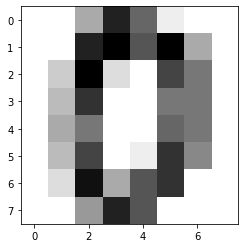

In [3]:
first_image = data.iloc[0]
np_image = first_image.values
np_image = np_image.reshape(8,8)
plt.imshow(np_image,cmap='gray_r')

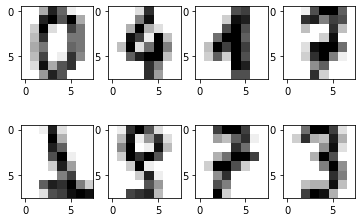

In [4]:
f,ax = plt.subplots(2,4)
ax[0,0].imshow(data.iloc[0].values.reshape(8,8),cmap='gray_r')
ax[0,1].imshow(data.iloc[100].values.reshape(8,8),cmap='gray_r')
ax[0,2].imshow(data.iloc[200].values.reshape(8,8),cmap='gray_r')
ax[0,3].imshow(data.iloc[300].values.reshape(8,8),cmap='gray_r')
ax[1,0].imshow(data.iloc[1000].values.reshape(8,8),cmap='gray_r')
ax[1,1].imshow(data.iloc[1100].values.reshape(8,8),cmap='gray_r')
ax[1,2].imshow(data.iloc[1200].values.reshape(8,8),cmap='gray_r')
ax[1,3].imshow(data.iloc[1300].values.reshape(8,8),cmap='gray_r')


## K-Nearest Neighbors Algorithm

While linear and logistic regression models make assumptions about the linearity between the features and the output labels, the k-nearest neighbors algorithm make no such assumption. This allows them to capture nonlinearity in the data.

Let's apply this algorithm to our image data.

### Pipeline for Training and Testing KNN models

We will create several functions to simplify the process of testing and training various KNN models. A fuction to train, test, and cross validate will be created so we can experiment with different hyperparameters effectively.

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

def train_knn(n,train_features,train_labels):
    knn = KNeighborsClassifier(n_neighbors = n)
    knn.fit(train_features,train_labels)
    return knn

def test(model,test_features,test_labels):
    predictions = model.predict(test_features)
    train_test_df = pd.DataFrame()
    train_test_df['correct_label'] = test_labels
    train_test_df['predicted_label'] = predictions
    overall_accuracy = sum(train_test_df['correct_label'] == train_test_df['predicted_label'])/len(train_test_df)
    return overall_accuracy

def cross_validate(k):
    fold_accuracies = []
    kf = KFold(n_splits = 4,random_state = 2)
    for train_index,test_index in kf.split(data):
        train_features,test_features = data.loc[train_index],data.loc[test_index]
        train_labels,test_labels = labels.loc[train_index],labels.loc[test_index]
        model = train_knn(k,train_features,train_labels)
        accuracy = test(model,test_features,test_labels)
        fold_accuracies.append(accuracy)
        fold_accuracies_mean = np.mean(fold_accuracies)
    return fold_accuracies_mean

knn_one_accuracy = cross_validate(1)
display(knn_one_accuracy)

0.9677233358079684

### Hyperparameter Optimization

Now that we have build our knn pipeline, let's experiment with different k values and model the model's performance

Text(0.5, 1.0, 'Mean Accuracy vs k')

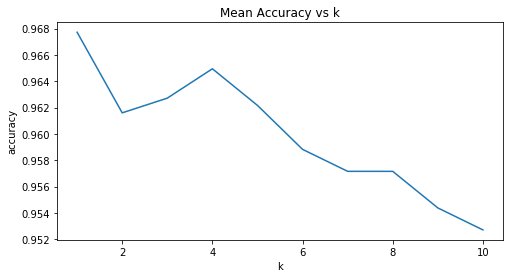

In [6]:
k_values = [x for x in range(1,11)]

k_accuracies = []
for k in k_values:
    accuracy = cross_validate(k)
    k_accuracies.append(accuracy)

plt.figure(figsize = (8,4))
plt.plot(k_values,k_accuracies)
plt.xlabel('k')
plt.ylabel('accuracy')
plt.title('Mean Accuracy vs k')

This model performs the best with a k value of 1. A k-value between 1-4 produces strong results, however after a k value of 4 the performance of the model begins to noticably fall.

There are a few downsides to using k-nearest neighbors:
1. high memory usage (for each new unseen observation, many comparisons need to be made to seen observations)
2. no model representation to debug and explore

## Neural Network Models with One Hidden Layer

Let's now explore using a neural network model to classify the handwritten digits. We will begin with just one hidden layer first, and then explore expanding the depth of our model

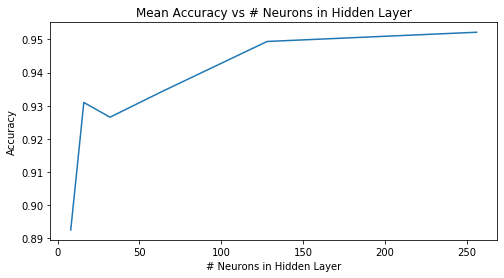

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier

def train_nn(hidden_layer_nodes,train_features,train_labels):
    mlp = MLPClassifier(hidden_layer_sizes = hidden_layer_nodes,max_iter = 1000)
    mlp.fit(train_features,train_labels)
    return mlp

def test_nn(model,test_features,test_labels):
    predictions = model.predict(test_features)
    train_test_df = pd.DataFrame()
    train_test_df['correct_label'] = test_labels
    train_test_df['predicted_label'] = predictions
    overall_accuracy = sum(train_test_df['correct_label'] == train_test_df['predicted_label'])/len(train_test_df)
    return overall_accuracy

def cross_validation_nn(neurons):
    fold_accuracies = []
    kf = KFold(n_splits = 4,random_state = 2)
    for train_index,test_index in kf.split(data):
        train_features,test_features = data.loc[train_index],data.loc[test_index]
        train_labels,test_labels = labels.loc[train_index],labels.loc[test_index]
        
        model = train_nn(neurons,train_features,train_labels)
        accuracy = test_nn(model,test_features,test_labels)
        fold_accuracies.append(accuracy)
        fold_accuracies_mean = np.mean(fold_accuracies)
    return fold_accuracies_mean

neurons_one = [(8,),
           (16,),
           (32,),
           (64,),
           (128,),
           (256,)]

nn_one_accuracies = []
for n in neurons_one:
    accuracy = cross_validation_nn(n)
    nn_one_accuracies.append(accuracy)

x= [i[0] for i in neurons_one]
plt.figure(figsize=(8,4))
plt.title('Mean Accuracy vs # Neurons in Hidden Layer')
plt.xlabel('# Neurons in Hidden Layer')
plt.ylabel('Accuracy')
plt.plot(x,nn_one_accuracies)

### Summary

Adding more neurons to the single hidden layer greatly improved simple accuracy from <90% to over 95% accuracy. Simple accuracy computes the number of correct classfications made, but does not tell us about false or true positives or negatives.

Given that the KNN model produced accuracies of about 96%, a single hidden layer neural network does not have any advantages to this problem

## Neural Network with Two Hidden Layers

Let's try using two hidden layers and continue to increase the number of neurons in each layer.

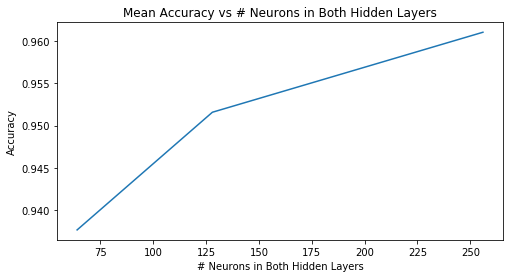

In [8]:
neurons_two = [(64,64),
           (128,128),
           (256,256)]

nn_two_accuracies = []
for n in neurons_two:
    accuracy = cross_validation_nn(n)
    nn_two_accuracies.append(accuracy)

x= [64,128,256]
plt.figure(figsize=(8,4))
plt.title('Mean Accuracy vs # Neurons in Both Hidden Layers')
plt.xlabel('# Neurons in Both Hidden Layers')
plt.ylabel('Accuracy')
plt.plot(x,nn_two_accuracies)

### Summary

Using 2 hidden layers improved our simple accuracy to 95%. I would be worried about overfitting, however using 4-fold cross validation gives me assurance that the model is generalizing to acheive the increase in accuracy over the single hidden layer network.

## Neural Network with Three Hidden Layers

Using more hidden layers is known to increase the amount of overfitting that happens. To help prevent overfitting, let's increase the number of folds we use for k-fold cross validation to 6 while testing networks with 3 hidden layers

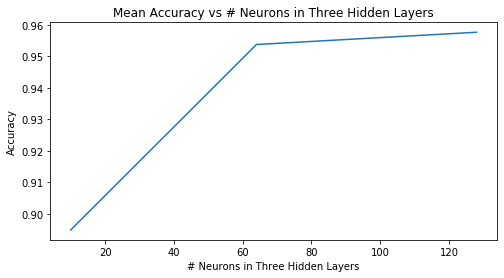

In [9]:
def cross_validation_nn(neurons):
    fold_accuracies = []
    kf = KFold(n_splits = 6,random_state = 2)
    for train_index,test_index in kf.split(data):
        train_features,test_features = data.loc[train_index],data.loc[test_index]
        train_labels,test_labels = labels.loc[train_index],labels.loc[test_index]
        
        model = train_nn(neurons,train_features,train_labels)
        accuracy = test_nn(model,test_features,test_labels)
        fold_accuracies.append(accuracy)
        fold_accuracies_mean = np.mean(fold_accuracies)
    return fold_accuracies_mean

neurons_three = [(10,10,10),
               (64,64,64),
               (128,128,128)]

nn_three_accuracies = []
for n in neurons_three:
    accuracy = cross_validation_nn(n)
    nn_three_accuracies.append(accuracy)

x= [10,64,128]
plt.figure(figsize=(8,4))
plt.title('Mean Accuracy vs # Neurons in Three Hidden Layers')
plt.xlabel('# Neurons in Three Hidden Layers')
plt.ylabel('Accuracy')
plt.plot(x,nn_three_accuracies)

### Summary

Using 3 hidden layers improved our simple accuracy to 96%, even with 6-fold cross validation. This is in line with research literature about deep neural networks for computer vision: having more layers and more neurons tends to improve the network's performance.



## Exploring Different Activation Functions

We used the ReLU activation function in our analysis of neural networks above. We can also use tanh, sigmoid, other activation functions to try to improve accuracy. We will stick with a 2 layer neural network and 4 folds to prevent overfitting.

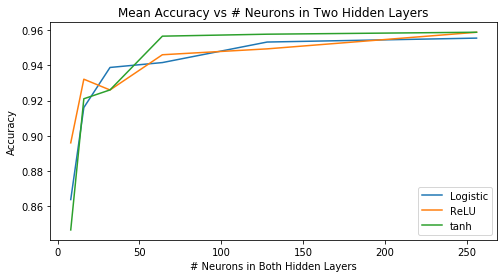

In [10]:
def train_nn(hidden_layer_nodes,train_features,train_labels):
    mlp = MLPClassifier(hidden_layer_sizes = hidden_layer_nodes,max_iter = 1000)
    mlp.fit(train_features,train_labels)
    return mlp

neurons_two = [(8,8),
               (16,16),
               (32,32),
               (64,64),
               (128,128),
               (256,256)]

nn_two_accuracies_reLU = []
for n in neurons_one:
    accuracy = cross_validation_nn(n)
    nn_two_accuracies_reLU.append(accuracy)

def train_nn(hidden_layer_nodes,train_features,train_labels):
    mlp = MLPClassifier(hidden_layer_sizes = hidden_layer_nodes,max_iter = 1000,activation = 'logistic')
    mlp.fit(train_features,train_labels)
    return mlp

nn_two_accuracies_log = []
for n in neurons_two:
    accuracy = cross_validation_nn(n)
    nn_two_accuracies_log.append(accuracy)    

    
def train_nn(hidden_layer_nodes,train_features,train_labels):
    mlp = MLPClassifier(hidden_layer_sizes = hidden_layer_nodes,max_iter = 1000,activation = 'tanh')
    mlp.fit(train_features,train_labels)
    return mlp   

nn_two_accuracies_tanh = []
for n in neurons_two:
    accuracy = cross_validation_nn(n)
    nn_two_accuracies_tanh.append(accuracy)

x= [i[0] for i in neurons_two]
plt.figure(figsize=(8,4))
plt.title('Mean Accuracy vs # Neurons in Two Hidden Layers')
plt.xlabel('# Neurons in Both Hidden Layers')
plt.ylabel('Accuracy')
plt.plot(x,nn_two_accuracies_log,label='Logistic')
plt.plot(x,nn_two_accuracies_reLU,label='ReLU')
plt.plot(x,nn_two_accuracies_tanh,label='tanh')
plt.legend()

### Summary

With fewer neurons (<32), ReLU performs better than the other activation functions. However, when >= 32 neurons are added to a layer, the ReLU activation function is more inaccurate than the tanh and logistic functions.

Logistic and tanh have similar performance, however tanh performs slightly better on average. I would recommend using one of these two activation functions for the best results.

## Decision Trees

We will use the DecisionTreeRegressor class to build a decision tree model. We will tune the hyperparameters min_samples_leaf and max_depth.

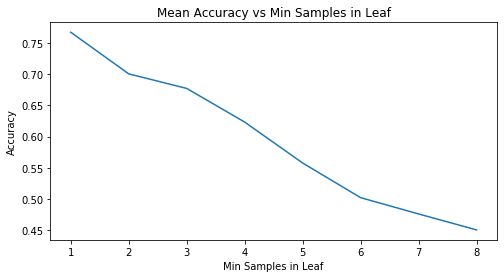

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor

def train_nn(min_samples,train_features,train_labels):
    mlp = DecisionTreeRegressor(min_samples_leaf = min_samples)
    mlp.fit(train_features,train_labels)
    return mlp

def test_nn(model,test_features,test_labels):
    predictions = model.predict(test_features)
    train_test_df = pd.DataFrame()
    train_test_df['correct_label'] = test_labels
    train_test_df['predicted_label'] = predictions
    overall_accuracy = sum(train_test_df['correct_label'] == train_test_df['predicted_label'])/len(train_test_df)
    return overall_accuracy

def cross_validation_nn(min_samples):
    fold_accuracies = []
    kf = KFold(n_splits = 4,random_state = 2)
    for train_index,test_index in kf.split(data):
        train_features,test_features = data.loc[train_index],data.loc[test_index]
        train_labels,test_labels = labels.loc[train_index],labels.loc[test_index]
        
        model = train_nn(min_samples,train_features,train_labels)
        accuracy = test_nn(model,test_features,test_labels)
        fold_accuracies.append(accuracy)
        fold_accuracies_mean = np.mean(fold_accuracies)
    return fold_accuracies_mean

min_samples = [1,2,3,4,5,6,7,8]

dt_accuracies = []
for s in min_samples:
    accuracy = cross_validation_nn(s)
    dt_accuracies.append(accuracy)

x= [i for i in min_samples]
plt.figure(figsize=(8,4))
plt.title('Mean Accuracy vs Min Samples in Leaf')
plt.xlabel('Min Samples in Leaf')
plt.ylabel('Accuracy')
plt.plot(x,dt_accuracies)

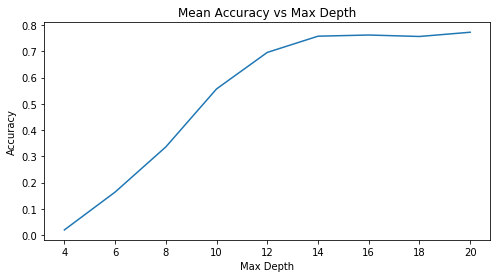

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor

def train_nn(depth,train_features,train_labels):
    mlp = DecisionTreeRegressor(max_depth = depth)
    mlp.fit(train_features,train_labels)
    return mlp

def test_nn(model,test_features,test_labels):
    predictions = model.predict(test_features)
    train_test_df = pd.DataFrame()
    train_test_df['correct_label'] = test_labels
    train_test_df['predicted_label'] = predictions
    overall_accuracy = sum(train_test_df['correct_label'] == train_test_df['predicted_label'])/len(train_test_df)
    return overall_accuracy

def cross_validation_nn(depth):
    fold_accuracies = []
    kf = KFold(n_splits = 4,random_state = 2)
    for train_index,test_index in kf.split(data):
        train_features,test_features = data.loc[train_index],data.loc[test_index]
        train_labels,test_labels = labels.loc[train_index],labels.loc[test_index]
        
        model = train_nn(depth,train_features,train_labels)
        accuracy = test_nn(model,test_features,test_labels)
        fold_accuracies.append(accuracy)
        fold_accuracies_mean = np.mean(fold_accuracies)
    return fold_accuracies_mean

max_depth = [4,6,8,10,12,14,16,18,20]

dt_accuracies = []
for d in max_depth:
    accuracy = cross_validation_nn(d)
    dt_accuracies.append(accuracy)

x= [i for i in max_depth]
plt.figure(figsize=(8,4))
plt.title('Mean Accuracy vs Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.plot(x,dt_accuracies)

### Summary

The decision tree model performed very poorly compared to neural networks and KNN models. The best accuracy a decision tree model produced was roughly onlu 80% accuracy. We found that a min_sample_leaf value of 1 produces the strongest results, but does not produce the most accurate tree model. After a max_depth value of 16, it appears the accuracy of the decision tree model levels off around 77-80%.

## Random Forest Model

We will use the RandomForestRegressor class to build a decision tree model. We will tune the hyperparameters min_samples_leaf and max_depth and n_estimators.

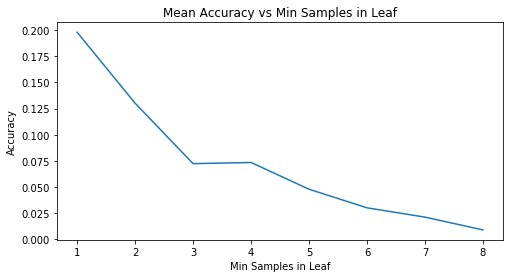

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor

train_features = data.iloc[0:898]
test_features = data.iloc[898:]

train_labels = labels.iloc[0:898]
test_labels= labels.iloc[898:]

def train_nn(min_samples,train_features,train_labels):
    mlp = RandomForestRegressor(min_samples_leaf = min_samples)
    mlp.fit(train_features,train_labels)
    return mlp

def test_nn(model,test_features,test_labels):
    predictions = model.predict(test_features)
    train_test_df = pd.DataFrame()
    train_test_df['correct_label'] = test_labels
    train_test_df['predicted_label'] = predictions
    overall_accuracy = sum(train_test_df['correct_label'] == train_test_df['predicted_label'])/len(train_test_df)
    return overall_accuracy

def cross_validation_nn(min_samples):
    model = train_nn(min_samples,train_features,train_labels)
    accuracy = test_nn(model,test_features,test_labels)
    return accuracy

min_samples = [1,2,3,4,5,6,7,8]

rf_accuracies = []
for s in min_samples:
    accuracy = cross_validation_nn(s)
    rf_accuracies.append(accuracy)

x= [i for i in min_samples]
plt.figure(figsize=(8,4))
plt.title('Mean Accuracy vs Min Samples in Leaf')
plt.xlabel('Min Samples in Leaf')
plt.ylabel('Accuracy')
plt.plot(x,rf_accuracies)

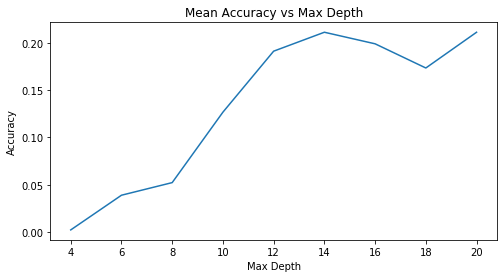

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

def train_nn(depth,train_features,train_labels):
    mlp = RandomForestRegressor(max_depth = depth)
    mlp.fit(train_features,train_labels)
    return mlp

def test_nn(model,test_features,test_labels):
    predictions = model.predict(test_features)
    train_test_df = pd.DataFrame()
    train_test_df['correct_label'] = test_labels
    train_test_df['predicted_label'] = predictions
    overall_accuracy = sum(train_test_df['correct_label'] == train_test_df['predicted_label'])/len(train_test_df)
    return overall_accuracy

def cross_validation_nn(depth):
    model = train_nn(depth,train_features,train_labels)
    accuracy = test_nn(model,test_features,test_labels)
    return accuracy

max_depth = [4,6,8,10,12,14,16,18,20]

rf_accuracies = []
for d in max_depth:
    accuracy = cross_validation_nn(d)
    rf_accuracies.append(accuracy)

x= [i for i in max_depth]
plt.figure(figsize=(8,4))
plt.title('Mean Accuracy vs Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.plot(x,rf_accuracies)

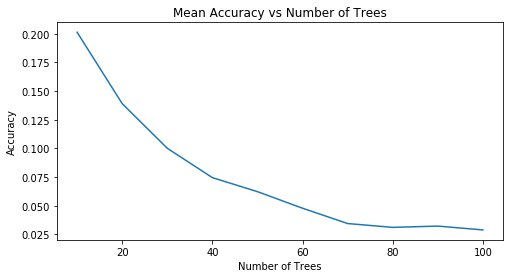

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

def train_nn(n,train_features,train_labels):
    mlp = RandomForestRegressor(n_estimators = n)
    mlp.fit(train_features,train_labels)
    return mlp

def test_nn(model,test_features,test_labels):
    predictions = model.predict(test_features)
    train_test_df = pd.DataFrame()
    train_test_df['correct_label'] = test_labels
    train_test_df['predicted_label'] = predictions
    overall_accuracy = sum(train_test_df['correct_label'] == train_test_df['predicted_label'])/len(train_test_df)
    return overall_accuracy

def cross_validation_nn(n):
    model = train_nn(n,train_features,train_labels)
    accuracy = test_nn(model,test_features,test_labels)
    return accuracy


n_values = [10,20,30,40,50,60,70,80,90,100]

rf_accuracies = []
for n in n_values:
    accuracy = cross_validation_nn(n)
    rf_accuracies.append(accuracy)

x= [i for i in n_values]
plt.figure(figsize=(8,4))
plt.title('Mean Accuracy vs Number of Trees')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.plot(x,rf_accuracies)

### Summary

The random forest model was extremely inaccurate in predicting the handwritten digits, with the best accuracy at 22.5%. It is not recommended to use this model


## Conclusion

In this project, I experimented with different models to classify handwritten digits. 

I found that the k-nearest neighbors algorithm produced the highest accuracy of roughy 96.8%. Despite being the most accurate, drawbacks of this algorithm include high memory usage and a lack of model representation to debug and explore.

I also explored building a deep neural network model to classify the handwritten digits. We found that this model did not produce as accurate results as the KNN algorithm. As we added more layers, we found that the model's accuracy improved. One risk of adding more layers to increase accuracy is overfitting the model. To prevent overfitting, we increased the number of folds our model used to train and test.

We also explored which activation functions in the MLPClassifier class produced the best results. We found that the logistic and tanh activation functions produce models with higher accuracies than ReLU.

Decision Trees and Random Forest models were also explored, however, they produced abysmal results, with very low accuracies compared to KNN and Neural Networks. I would not recommend using decision trees or random forests to predict the handwritten digit. This is likely because the features that were available in this dataset were just pixel intensities, and the overall combination of pixels is what determines the number. Neural networks are able to learn hierarchial representations, while decision trees cannot. 

After researching 4 different machine learning models, the order of accuracy was as follows:

1. KNN Algorithm
2. Neural Network with Three Hidden Layers (logistic or tanh activation functions are the most accurate)
3. Decision Trees
4. Random Forest